In [1]:
import random
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
from tqdm.auto import tqdm

from torch.utils.data import DataLoader
from torcheval.metrics.functional import binary_auroc
import matplotlib.pyplot as plt

from data_helpers import get_data, get_split_indices, get_torch_dataset
from modules import FTTransformer, FeatureTokenizer, TransformerEncoder
from training_helpers import seed_everything

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Load the data

seed_everything(42)

mode = "extrapolate"

data = get_data("splot")

data["y"] = data["y"][:, data["y"].sum(axis=0) > 20]

n_features = data["tabular_x"].shape[1]
n_samples, n_species = data["y"].shape

train_indices, val_indices, test_indices = get_split_indices(data, mode=mode)

data["x_train"], data["y_train"] = data["tabular_x"][train_indices], data["y"][train_indices]
data["x_val"], data["y_val"] = data["tabular_x"][val_indices], data["y"][val_indices]
data["x_test"], data["y_test"] = data["tabular_x"][test_indices], data["y"][test_indices]
data["satclip_embeddings_train"] = data["satclip_embeddings"][train_indices]
data["satclip_embeddings_test"] = data["satclip_embeddings"][test_indices]
data["satclip_embeddings_val"] = data["satclip_embeddings"][val_indices]

train_mean = np.nanmean(data["x_train"], axis=0)
train_std = np.nanstd(data["x_train"], axis=0)
data["x_test"] = (data["x_test"] - train_mean)/(train_std + 0.0001)
data["x_val"] = (data["x_val"] - train_mean)/(train_std + 0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 1024
test_loader = DataLoader(get_torch_dataset({"dataset": "splot"}, data["x_test"], data["y_test"], data["satclip_embeddings_test"]),
                            batch_size=batch_size, shuffle=False)
val_loader = DataLoader(get_torch_dataset({"dataset": "splot"}, data["x_val"], data["y_val"], data["satclip_embeddings_val"]),
                            batch_size=batch_size, shuffle=False)

In [5]:
d_hidden = 192
n_layers = 6
n_heads = 8
n_blocks = 7
dropout = 0.1

feature_tokenizer = FeatureTokenizer(n_features=n_features, d_token=d_hidden)
transformer_encoder = TransformerEncoder(d_token=d_hidden, n_blocks=n_blocks, n_heads=n_heads, dropout=dropout)
model = FTTransformer(feature_tokenizer=feature_tokenizer, transformer_encoder=transformer_encoder, 
                      d_hidden=d_hidden, d_out=n_species).to(device)

model.load_state_dict(torch.load(f"models/masksdm/epoch_178.pt"))
model.eval()
print("Model loaded")

Model loaded


In [6]:
indices_non_zeros_samples = np.intersect1d(np.sum(data[f"y_train"], axis=0).nonzero(), 
                                    np.sum(data["y_val"], axis=0).nonzero(), np.sum(data["y_test"], axis=0).nonzero()).tolist()

def evaluate(model, dataloader, excluded_variables, satclip=True):
    
    with torch.no_grad():
        
        preds = []
        y = []
        for batch in dataloader:
            
            x_batch, y_batch, satclip_embeddings = batch
            x_mask = (~torch.isnan(x_batch))
            if excluded_variables is not None:
                x_mask[:, excluded_variables] = 0
            if satclip:
                satclip_embeddings_mask = torch.tensor(np.ones(len(satclip_embeddings)))
            else:
                satclip_embeddings_mask = torch.tensor(np.zeros(len(satclip_embeddings)))
                    
            y_pred = model(x_batch.to(device), satclip_embeddings.to(device), 
                           x_mask=x_mask.to(device), satclip_embeddings_mask=satclip_embeddings_mask.to(device)).detach()
            preds.append(y_pred)
            y.append(y_batch)

        preds = torch.concatenate(preds, axis=0).float()
        y = torch.concatenate(y, axis=0).to(device).int()
        
        aucs = binary_auroc(preds[:, indices_non_zeros_samples].T, 
                           y[:, indices_non_zeros_samples].T, num_tasks=len(indices_non_zeros_samples)).cpu().numpy()
        auc = round(aucs.mean().item() * 100, 1)
        return aucs, auc

In [7]:
tabular_names = np.array(data["tabular_names"])

wc_indices = list(range(19))
print("WorldClim:")
print(wc_indices)
print(tabular_names[wc_indices])

sg_indices = list(range(19, 27))
print("\nSoilGrids:")
print(sg_indices)
print(tabular_names[sg_indices])

loc_indices = list(range(27, 29))
print("\nLocation:")
print(loc_indices)
print(tabular_names[loc_indices])

topo_indices = list(range(29, 32))
print("\nTopography:")
print(topo_indices)
print(tabular_names[topo_indices])

meta_indices = list(range(32, 34))
print("\nMetadata:")
print(meta_indices)
print(tabular_names[meta_indices])

cover_indices = list(range(34, 45))
print("\nCover:")
print(cover_indices)
print(tabular_names[cover_indices])

height_indices = list(range(45, 52))
print("\nHeight:")
print(height_indices)
print(tabular_names[height_indices])

humans_indices = list(range(52, 61))
print("\nHumans influence:")
print(humans_indices)
print(tabular_names[humans_indices])

###

metaplus_indices = list(range(32, 52))
print("\nMetadata + Cover + Height:")
print(metaplus_indices)
print(tabular_names[metaplus_indices])

WorldClim:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
['bio_1' 'bio_2' 'bio_3' 'bio_4' 'bio_5' 'bio_6' 'bio_7' 'bio_8' 'bio_9'
 'bio_10' 'bio_11' 'bio_12' 'bio_13' 'bio_14' 'bio_15' 'bio_16' 'bio_17'
 'bio_18' 'bio_19']

SoilGrids:
[19, 20, 21, 22, 23, 24, 25, 26]
['ORCDRC' 'PHIHOX' 'CECSOL' 'BDTICM' 'CLYPPT' 'SLTPPT' 'SNDPPT' 'BLDFIE']

Location:
[27, 28]
['Longitude' 'Latitude']

Topography:
[29, 30, 31]
['Elevation' 'Slope' 'Aspect']

Metadata:
[32, 33]
['Location_uncertainty' 'Releve_area']

Cover:
[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
['Cover_total' 'Cover_tree_layer' 'Cover_shrub_layer' 'Cover_herb_layer'
 'Cover_moss_layer' 'Cover_lichen_layer' 'Cover_algae_layer'
 'Cover_litter_layer' 'Cover_bare_rocks' 'Cover_cryptogams'
 'Cover_bare_soil']

Height:
[45, 46, 47, 48, 49, 50, 51]
['Height_trees_highest' 'Height_trees_lowest' 'Height_shrubs_highest'
 'Height_shrubs_lowest' 'Height_herbs_average' 'Height_herbs_lowest'
 'Height_herbs_highest']

Humans

# Groups of predictors

In [8]:
subsets = [wc_indices, sg_indices, topo_indices, loc_indices, metaplus_indices, humans_indices]
group_names = ["WorldClim", "SoilGrids", "Topography", "Location", "Metadata", "Humans influence"]
d = len(subsets)
num_combinations = 2**d

# All possible predictor groups subsets
combinations = np.array([list(np.binary_repr(i, width=d)) for i in range(num_combinations)], dtype=int)
performances = []

# Compute performance for each subset
for combination in combinations:
    excluded_variables = []
    for i, s in enumerate(combination):
        if s == 0:
            excluded_variables.append(subsets[i])
    
    if excluded_variables:
        excluded_variables = np.concatenate(excluded_variables)
    else:
        excluded_variables = None
    _, auc= evaluate(model, test_loader, excluded_variables , satclip=False)
    performances.append(auc)

In [9]:
shapley_values_groups = []

factorials = factorial(range(d+1))

# Compute exact Shapley values
for variable in range(d):
    total_sum = 0
    i_combinations = [i for i, c in enumerate(combinations) if c[variable] == 1]
    for i_combination in i_combinations:
        i_combination_without = combinations[i_combination].copy()
        i_combination_without[variable] = 0
        for j, c in enumerate(combinations):
            if list(c) == list(i_combination_without):
                corresponding_j = j
        diff = performances[i_combination] - performances[corresponding_j]
        S_size = combinations[corresponding_j].sum()
        total_sum += diff * factorials[S_size] * factorials[d - S_size - 1]

    shapley_value = round(total_sum / factorials[d], 2)
    shapley_values_groups.append(shapley_value)

In [10]:
for i, shapley_value in enumerate(shapley_values_groups):
    print(f"{group_names[i]}: {shapley_value}")

WorldClim: 9.31
SoilGrids: 8.18
Topography: 4.73
Location: 8.9
Metadata: 7.02
Humans influence: 4.45


# All predictors

### Uniform Monte-Carlo

In [ ]:
def compute_shapley_uniform_MC(subset_of_interest, subsets, num_evals=1000, model=model, loader=test_loader, use_satclip=False):
    
    print(f"Computing Shapley values for subset: {tabular_names[subset_of_interest]}")
    
    subsets_without = subsets.copy()
    subsets_without.remove(subset_of_interest)
    
    marginal_contributions = []
    variables = [x for xs in subsets for x in xs]
    unconsidered_variables = [x for x in range(61) if x not in variables]
    for i in range(num_evals):
        excluded_variables = random.sample(subsets_without, random.randint(0, len(subsets_without)))
        excluded_variables = [x for xs in excluded_variables for x in xs]
        excluded_variables = excluded_variables + unconsidered_variables
        if use_satclip == True:
            satclip = random.choice([True, False])
        else:
            satclip = False
        _, auc_with = evaluate(model, loader, excluded_variables , satclip=satclip)
        _, auc_without = evaluate(model, loader, excluded_variables + subset_of_interest, satclip=satclip)
        marginal_contributions.append(auc_with - auc_without)
            
    return marginal_contributions

num_evals = 732
subsets = []
for i in range(n_features):
    subsets.append([i])
uniform_MC_SV = []
for subset_of_interest in subsets:
    marginal_contributions = compute_shapley_uniform_MC(subset_of_interest, subsets, num_evals)
    marginal_contributions = np.cumsum(marginal_contributions)/np.array((range(1, num_evals+1)))
    uniform_MC_SV.append(marginal_contributions)
    
uniform_MC_SV = np.array(uniform_MC_SV)
np.save(f"results/uniform_global_shapley_values.npy", uniform_MC_SV)

### Stratified Monte-Carlo with Latin squares

In [ ]:
def generate_latin_square(n):

    base = np.arange(n)
    latin_square = np.zeros((n, n), dtype=int)
    for i in range(n):
        latin_square[i] = np.roll(base, i)
    permuted_indices = np.random.permutation(list(range(n)))
    latin_square[:] = latin_square[:, permuted_indices]
    return latin_square

seed_everything(42)

num_ls = 25
subsets = list(range(n_features))
num_subsets = n_features
shapley_values = np.zeros((num_ls * num_subsets, num_subsets))
with tqdm(total=num_ls * num_subsets * num_subsets, position=0, leave=True) as pbar:
    for j in range(num_ls):
        ls = generate_latin_square(num_subsets)
        for i in range(num_subsets):
            row = ls[i]
            excluded_variables = subsets.copy()
            _, prev_auc = evaluate(model, test_loader, excluded_variables, satclip=False)
            temp_shapley_values = np.zeros(num_subsets)
            for s in row:
                excluded_variables.remove(s)
                _, cur_auc = evaluate(model, test_loader, excluded_variables , satclip=False)
                delta = cur_auc - prev_auc
                temp_shapley_values[s] += delta
                prev_auc = cur_auc
                pbar.update(1)
            
            shapley_values[j * num_subsets + i] = temp_shapley_values
            
            np.save(f"results/temp_stratified_global_shapley_values.npy", shapley_values)

np.save(f"results/stratified_global_shapley_values.npy", shapley_values)

In [14]:
shapley_values = np.load("results/stratified_global_shapley_values.npy")
shapley_values = np.cumsum(shapley_values[:1464], axis=0) / np.array((range(1, 1464+1)))[:, np.newaxis]
shapley_values = np.round(shapley_values, 2)

In [15]:
for name, sh in zip(tabular_names, shapley_values[-1, :]):
    print(f"{name}: {sh}")

bio_1: 1.44
bio_2: 1.15
bio_3: 1.52
bio_4: 1.52
bio_5: 1.33
bio_6: 1.56
bio_7: 1.41
bio_8: 1.25
bio_9: 1.26
bio_10: 1.32
bio_11: 1.58
bio_12: 1.15
bio_13: 1.12
bio_14: 1.08
bio_15: 0.89
bio_16: 1.18
bio_17: 1.1
bio_18: 1.18
bio_19: 0.99
ORCDRC: 0.94
PHIHOX: 1.09
CECSOL: 0.66
BDTICM: 0.57
CLYPPT: 0.74
SLTPPT: 1.03
SNDPPT: 0.79
BLDFIE: 0.99
Longitude: 1.84
Latitude: 1.71
Elevation: 0.94
Slope: 0.63
Aspect: 0.0
Location_uncertainty: 0.57
Releve_area: 1.06
Cover_total: 0.33
Cover_tree_layer: 0.41
Cover_shrub_layer: 0.37
Cover_herb_layer: 0.52
Cover_moss_layer: 0.21
Cover_lichen_layer: 0.0
Cover_algae_layer: 0.0
Cover_litter_layer: 0.05
Cover_bare_rocks: 0.09
Cover_cryptogams: 0.02
Cover_bare_soil: 0.05
Height_trees_highest: 0.37
Height_trees_lowest: 0.01
Height_shrubs_highest: 0.09
Height_shrubs_lowest: 0.01
Height_herbs_average: 0.11
Height_herbs_lowest: -0.0
Height_herbs_highest: 0.03
HFP2009: 0.41
Built2009: 0.06
Croplands2005: 0.17
Lights2009: 0.28
Navwater2009: 0.2
Pasture2009: 0.28
P

## Convergence

In [ ]:
uniform_shapley_values = np.load("results/uniform_global_shapley_values.npy")

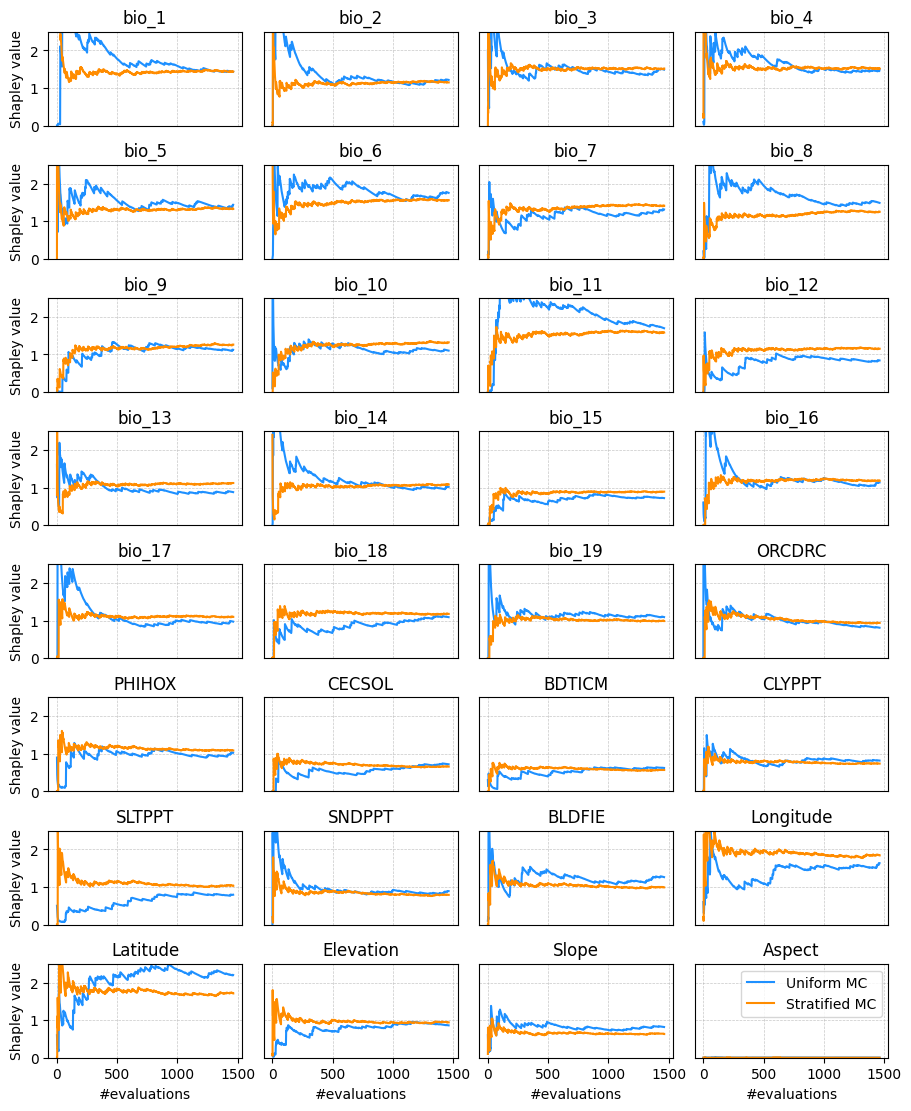

In [17]:
colors = ["darkorange", "dodgerblue"]

fig, axes = plt.subplots(8, 4, figsize=(9, 11), constrained_layout=True)
axes = axes.flatten()

for i in range(32):
    axes[i].plot(range(0, 2 * 732, 2), uniform_shapley_values[i], label='Uniform MC', color=colors[1])
    axes[i].plot(shapley_values[:, i], label='Stratified MC', color=colors[0])
    axes[i].set_title(f'{tabular_names[i]}')
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    axes[i].set_ylim(0, 2.5)
    axes[i].set_ylabel('Shapley value')
    axes[i].set_xlabel('#evaluations')

    # Show only left and bottom axes
    if i % 4 != 0:
        axes[i].tick_params(left=False, labelleft=False)
        axes[i].set_ylabel('')
    if i < 28:
        axes[i].tick_params(bottom=False, labelbottom=False)
        axes[i].set_xlabel('')
    if i == 31:
        axes[i].legend()

for j in range(32, len(axes)):
    axes[j].axis('off')

plt.savefig("figures/shapley_values_convergence_1.pdf", bbox_inches='tight')
plt.show()

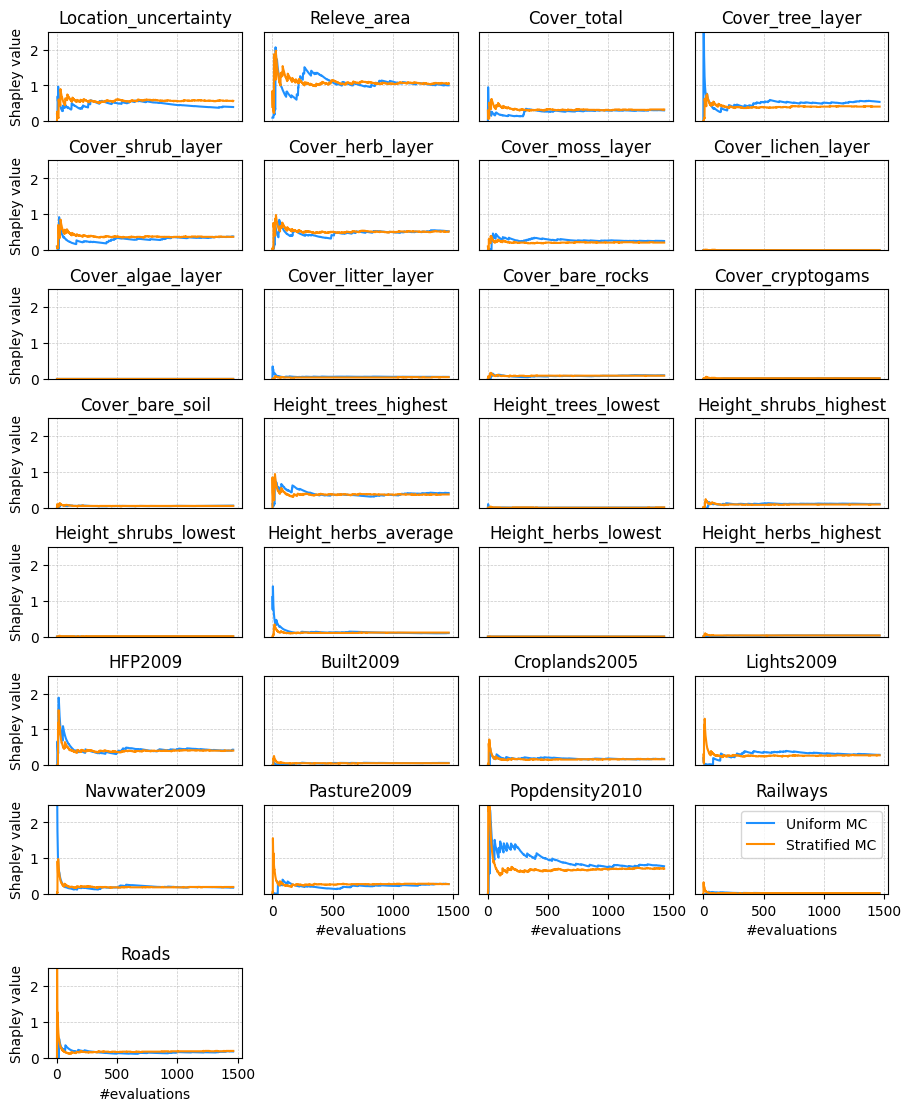

In [18]:
fig, axes = plt.subplots(8, 4, figsize=(9, 11), constrained_layout=True)
axes = axes.flatten()

for i in range(0, 29):
    axes[i].plot(range(0, 2 * 732, 2), uniform_shapley_values[i+32], label='Uniform MC', color=colors[1])
    axes[i].plot(shapley_values[:, i+32], label='Stratified MC', color=colors[0])
    axes[i].set_title(f'{tabular_names[i+32]}')
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    axes[i].set_ylim(0, 2.5)
    axes[i].set_ylabel('Shapley value')
    axes[i].set_xlabel('#evaluations')

    # Show only left and bottom axes
    if i % 4 != 0:
        axes[i].tick_params(left=False, labelleft=False)
        axes[i].set_ylabel('')
    if i < 25:
        axes[i].tick_params(bottom=False, labelbottom=False)
        axes[i].set_xlabel('')
    if i == 27:
        axes[i].legend()


for j in range(29, len(axes)):
    axes[j].axis('off')

plt.savefig("figures/shapley_values_convergence_2.pdf", bbox_inches='tight')
plt.show()